In [6]:
import torch
import MDAnalysis as mda
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
import os
import os.path as osp
import warnings
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

#from full_VGAE_egnn_clean import *

from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import pandas as pd
import torch_geometric.transforms as T
from torch_geometric.nn.pool import global_mean_pool
import math

from torch.utils.tensorboard import SummaryWriter
import itertools
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm


In [7]:
import sys
sys.path.append("LIBS")
from LIBS.utils import *
from LIBS.FGVAE import *

dataset = get_dataset(initial_alignment=True)

train_loader, val_loader, test_loader = get_dataloaders(dataset)


Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt

Scaling positions... Max absolute position values for scaling: tensor([28.9800, 29.0000, 29.0100])
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
Aligning the first frame to the origin ...
Aligning all the other frame to the first frame ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



In [5]:
# # plot the first graph in the dataset
# def plot_graph_pred(pos, true_pos_graph, ax = None, title='Graph',planewise=False):

#     k=0
#     if ax is None:

        
#         if not planewise:
#             fig = plt.figure(figsize=(10, 10))
#             ax = fig.add_subplot(111, projection='3d')
#             k=1
#         else:
#             fig = plt.figure(figsize=(15, 5))
#             k=0
   
#         palette = ["r", "g", "b", "y", "c", "m", "k"]


#         G = to_networkx(true_pos_graph, to_undirected=True)
#         pos_true = true_pos_graph.pos.numpy()

#         graph_pred = true_pos_graph.clone()
#         graph_pred.pos = pos
#         G_pred = to_networkx(graph_pred, to_undirected=True)

#         pos_pred = graph_pred.pos.numpy()

#         if planewise:
#             if ax is not None:
#                 raise ValueError("When planewise is True, ax should be None to create subplots.")
#             # Plot each plane separately
#             ax_names = ['X-Y Plane', 'X-Z Plane', 'Y-Z Plane']
#             ax_names_labels = ['X-axis', 'Y-axis', 'Z-axis']
#             for i in range(3):
#                 ax = fig.add_subplot(1, 3, i + 1)
#                 ax.set_title(ax_names[i])
#                 ax.set_xlabel(ax_names_labels[i % 3])
#                 ax.set_ylabel(ax_names_labels[(i + 1) % 3])

#                 if i == 0:
#                     pos_true_plane = pos_true[:, [0, 1, 2]]
#                     pos_pred_plane = pos_pred[:, [0, 1, 2]]
#                 elif i == 1:
#                     pos_true_plane = pos_true[:, [0, 2, 1]]
#                     pos_pred_plane = pos_pred[:, [0, 2, 1]]
#                 else:
#                     pos_true_plane = pos_true[:, [1, 2, 0]]
#                     pos_pred_plane = pos_pred[:, [1, 2, 0]]

#                 # Draw nodes
#                 ax.scatter(pos_true_plane[:, 0], pos_true_plane[:, 1],color=palette[0], s=50, label='graph_true')
#                 ax.scatter(pos_pred_plane[:, 0], pos_pred_plane[:, 1], color=palette[1], s=50, label='graph_pred')

#                 # Draw edges
#                 if i == 0:
#                     pos_true_edges = pos_true[:, [0, 1, 2]]
#                     pos_pred_edges = pos_pred[:, [0, 1, 2]]
#                 elif i == 1:
#                     pos_true_edges = pos_true[:, [0, 2, 1]]
#                     pos_pred_edges = pos_pred[:, [0, 2, 1]]
#                 else:
#                     pos_true_edges = pos_true[:, [1, 2, 0]]
#                     pos_pred_edges = pos_pred[:, [1, 2, 0]]

#                 for edge in G.edges():
#                     x = [pos_true_edges[edge[0], 0], pos_true_edges[edge[1], 0]]
#                     y = [pos_true_edges[edge[0], 1], pos_true_edges[edge[1], 1]]
#                     ax.plot(x, y, color=palette[0], alpha=0.5, linewidth=1)

#                 for edge in G_pred.edges():
#                     x = [pos_pred_edges[edge[0], 0], pos_pred_edges[edge[1], 0]]
#                     y = [pos_pred_edges[edge[0], 1], pos_pred_edges[edge[1], 1]]
#                     ax.plot(x, y, color=palette[1], alpha=0.5, linewidth=1)
#                     ax.grid(True)

#         else:
#             ax.set_title(title)
#             ax.set_xlabel('X-axis')
#             ax.set_ylabel('Y-axis')
#             ax.set_zlabel('Z-axis')

#             # Project the 3D positions onto the XY plane for visualization
#             pos_true_plane = pos_true[:, [0, 1, 2]]
#             pos_pred_plane = pos_pred[:, [0, 1, 2]]


#         if not planewise:
#         # Draw nodes
#             ax.scatter(pos_true_plane[:, 0], pos_true_plane[:, 1], pos_true_plane[:, 2], color = palette[0], s=50, label=f'graph_true')

#             ax.scatter(pos_pred_plane[:, 0], pos_pred_plane[:, 1], pos_pred_plane[:, 2], color = palette[1], s=50, label=f'graph_pred')

#             # Draw edges
#             for edge in G.edges():
#                 x = [pos_true[edge[0], 0], pos_true[edge[1], 0]]
#                 y = [pos_true[edge[0], 1], pos_true[edge[1], 1]]
#                 z = [pos_true[edge[0], 2], pos_true[edge[1], 2]]
#                 ax.plot(x, y, z, alpha=0.5, color=palette[0], linewidth=1)

#             for edge in G_pred.edges():
#                 x = [pos_pred[edge[0], 0], pos_pred[edge[1], 0]]
#                 y = [pos_pred[edge[0], 1], pos_pred[edge[1], 1]]
#                 z = [pos_pred[edge[0], 2], pos_pred[edge[1], 2]]
#                 ax.plot(x, y, z, alpha=0.5, color=palette[1], linewidth=1)

            
#             ax.quiver(pos_true[:, 0], pos_true[:, 1], pos_true[:, 2],
#                         pos_pred[:, 0] - pos_true[:, 0],
#                         pos_pred[:, 1] - pos_true[:, 1],
#                         pos_pred[:, 2] - pos_true[:, 2],
#                         color='k', alpha=0.4, linewidth =2, arrow_length_ratio = 0.05, label ='Displacement Vectors')


#     if k == 1:
#         ax.legend()
#         plt.tight_layout()
#         plt.show()
#     else:
        
#         ax.legend()
#         plt.tight_layout()
#         return ax


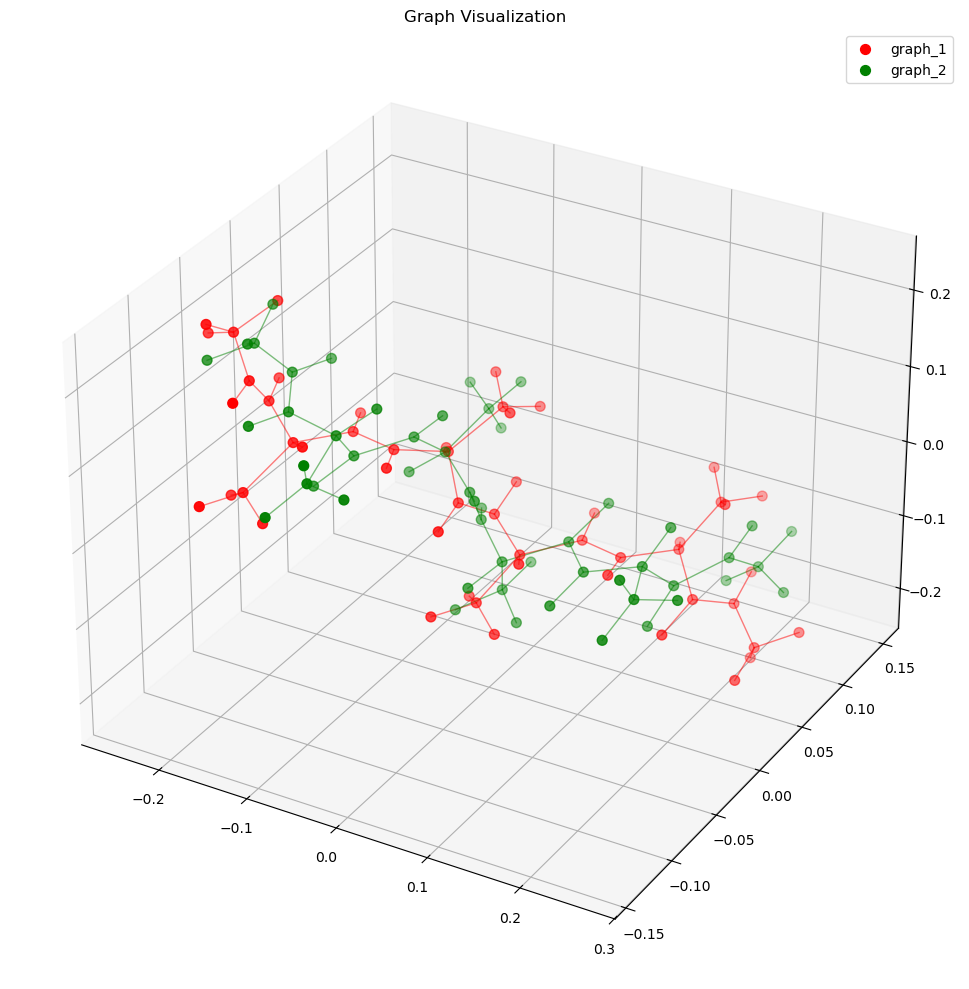

In [8]:
plot_graph_dataset(dataset, n_graphs=2, title='Graph Visualization')

In [4]:
# Load the models 
EPOCHS = 30
lrs= [ "0.0001", "0.00001", "0.000001"]
n_layers = [3, 5, 7, 9, 12]

ENCODER_TYPE = 'standard'
HIDDEN_ENCODER_CHANNELS = 256
OUT_ENCODER_CHANNELS = 128 
#NUM_ENC_LAYERS = 5
ATTENTION_ENCODER = True
LATENT_DIM = 128
TANH_ENCODER = False
NORMALIZE_ENCODER = False

# decoder
MLP_DECODER_POS_SIZE = [256,128,128]
HIDDEN_DECODER_CHANNELS = 256
#NUM_DEC_LAYERS = 5
ATTENTION_DECODER = True
TANH_DECODER = False
NORMALIZE_DECODER =  False

losses = {}
pos_pred_dict = {}
mean_dict = {}
log_var_dict = {}

for lr in lrs:
    for n_layer in n_layers:
        model = FGVAE(encoder=EGNN_Encoder(
            in_channels=dataset[0].num_features,
            hidden_channels_egnn=HIDDEN_ENCODER_CHANNELS,
            out_channels_egnn=OUT_ENCODER_CHANNELS,
            num_egnn_layers=n_layer,
            attention=ATTENTION_ENCODER,
            tanh=TANH_ENCODER,
            normalize=NORMALIZE_ENCODER,
            latent_dim=LATENT_DIM
        ),
        decoder=EGNN_Decoder(
            latent_dim=LATENT_DIM,
            node_feature_dim_initial=dataset[0].num_features,
            hidden_nf=HIDDEN_DECODER_CHANNELS,
            num_egnn_layers=n_layer,
            attention=ATTENTION_DECODER,
            tanh=TANH_DECODER,
            normalize=NORMALIZE_DECODER,
            pos_MLP_size=MLP_DECODER_POS_SIZE
            
        ))

        try:
            path_model = f'../JIMI_RUNS/model_{ENCODER_TYPE}/sim_lr_{lr}_layers_{n_layer}/model_epoch_{EPOCHS}.pth'
            model.load_state_dict(torch.load(path_model))
        
        except:
            try:
                print(f"Loading model with MLP decoder for lr={lr}, n_layers={n_layer}")
                MLP_DECODER_POS_SIZE = [256,256,128]

                model = FGVAE(encoder=EGNN_Encoder(
                    in_channels=dataset[0].num_features,
                    hidden_channels_egnn=HIDDEN_ENCODER_CHANNELS,
                    out_channels_egnn=OUT_ENCODER_CHANNELS,
                    num_egnn_layers=n_layer,
                    attention=ATTENTION_ENCODER,
                    tanh=TANH_ENCODER,
                    normalize=NORMALIZE_ENCODER,
                    latent_dim=LATENT_DIM
                ),
                decoder=EGNN_Decoder(
                    latent_dim=LATENT_DIM,
                    node_feature_dim_initial=dataset[0].num_features,
                    hidden_nf=HIDDEN_DECODER_CHANNELS,
                    num_egnn_layers=n_layer,
                    attention=ATTENTION_DECODER,
                    tanh=TANH_DECODER,
                    normalize=NORMALIZE_DECODER,
                    pos_MLP_size=MLP_DECODER_POS_SIZE
                    
                ))
                
                path_model = f'../JIMI_RUNS/model_{ENCODER_TYPE}/sim_lr_{lr}_layers_{n_layer}/model_epoch_{EPOCHS}.pth'
                model.load_state_dict(torch.load(path_model))


            except FileNotFoundError:
                print(f"Model file not found: {path_model}")
        

        model.eval()
        model = model.to('cuda')
        print(f'Loaded model with lr={lr}, n_layers={n_layer}')

        pos_pred_dict[(lr, n_layer)] = []
        mean_dict[(lr, n_layer)] = []
        log_var_dict[(lr, n_layer)] = []

        # Evaluate the model on the test set
        test_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                data = data.to('cuda')
                pos_pred, mean, log_var, batch_vec = model(data)
                loss = reconstruction_loss(pos_pred, data.pos,data.batch)
                test_loss += loss.item()
                pos_pred_dict[(lr, n_layer)].append(pos_pred)
                mean_dict[(lr, n_layer)].append(mean)
                log_var_dict[(lr, n_layer)].append(log_var)

        print(f'Test Loss for lr={lr}, n_layers={n_layer}: {test_loss / len(test_loader)}')

        losses[(lr, n_layer)] = test_loss / len(test_loader)




Loading model with MLP decoder for lr=0.0001, n_layers=3
Model file not found: ../JIMI_RUNS/model_standard/sim_lr_0.0001_layers_3/model_epoch_30.pth
Loaded model with lr=0.0001, n_layers=3
Test Loss for lr=0.0001, n_layers=3: 0.009560908816435083
Loading model with MLP decoder for lr=0.0001, n_layers=5
Model file not found: ../JIMI_RUNS/model_standard/sim_lr_0.0001_layers_5/model_epoch_30.pth
Loaded model with lr=0.0001, n_layers=5
Test Loss for lr=0.0001, n_layers=5: 0.00956783430862748
Loading model with MLP decoder for lr=0.0001, n_layers=7
Model file not found: ../JIMI_RUNS/model_standard/sim_lr_0.0001_layers_7/model_epoch_30.pth
Loaded model with lr=0.0001, n_layers=7


KeyboardInterrupt: 

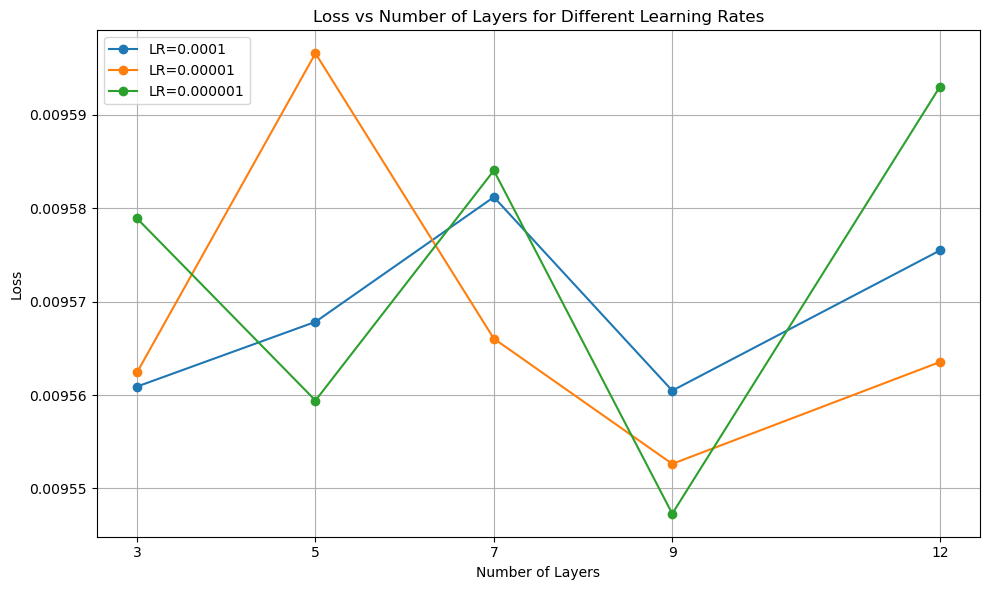

In [7]:
# plot the losses for fixed learning rates and varying number of layers
fig, ax = plt.subplots(figsize=(10, 6))
for lr in lrs:  
    layer_losses = [losses[(lr, n_layer)] for n_layer in n_layers if (lr, n_layer) in losses]
    ax.plot(n_layers[:len(layer_losses)], layer_losses, marker='o', label=f'LR={lr}')
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Number of Layers for Different Learning Rates')
ax.legend()
plt.xticks(n_layers)
plt.grid()
plt.tight_layout()
plt.show()

In [3]:
# extract the best pos prediction for lr=0.0001 and n_layers=9
_lr = "0.0001"
_n_layers = 9
pos_list = pos_pred_dict[(_lr, _n_layers)]
loss_list = []

pos_list = [pos.cpu() for pos in pos_list]  # Move tensors to CPU for loss computation

batch_vec = torch.zeros(len(pos_list[0]), dtype=torch.long)
for i in range(len(pos_list)):
    loss_list.append(reconstruction_loss(pos_list[i], dataset[i].pos,batch_vec))

# find the index of the minimum loss
min_loss_index = np.argmin(loss_list).item()
print(f'Minimum loss index: {min_loss_index}, Loss: {loss_list[min_loss_index]}')

# plot the best prediction
best_pos = pos_list[min_loss_index]
true_pos_graph = dataset[min_loss_index]


fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

plot_graph_pred(best_pos, true_pos_graph, ax=ax[0], title=f"reconstruction for data {min_loss_index} 3D", planewise=False,quiver=False)
plot_graph_pred(best_pos, true_pos_graph, ax=ax[1], title=f"reconstruction for data {min_loss_index} 3D", planewise=False)
plot_graph_pred(best_pos, true_pos_graph, title=f"reconstruction for data {min_loss_index} 2D", planewise=True,quiver=False)



NameError: name 'pos_pred_dict' is not defined